# General compression using INIF 

In [3]:
# import sys
import os
# sys.path.append('..')
import jax
import jax.numpy as jnp
import optax
import ipywidgets as widgets
from tqdm import tqdm
from IPython.display import clear_output
from utils import others, visualizer
from models import INR, HEVC

## 1. Read the raw data, set ROI and visualize the ROI

In [2]:
# set the root directory
root_directory = '/INIF/demo_data'
# set the default path, set to None if you want the first file in the directory
defualt_path = '/INIF/demo_data/TNNI1/TNNI1.tif'

# fetch all the files in the root directory
file_paths = []
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        file_paths.append(os.path.join(subdir, file))

# check if there are files in the directory
if not file_paths:
    print("No files found in the directory.")
else:
    # create a dropdown menu
    file_selector = widgets.Dropdown(
        options=file_paths,
        description='File path:',
        value = defualt_path if defualt_path else file_paths[0],
        disabled=False,
        continuous_update=False
    )
    # display the dropdown menu
    display(file_selector)

Dropdown(description='File path:', index=24, options=('/INIF/demo_data/Breast_Tumor/Patient_66_core_3…

In [3]:
meta_data = {}
raw_data = others.read_data(file_selector.value, meta_data)

The path to the file is:  /INIF/demo_data/TNNI1/TNNI1.tif
The shape of the raw data is: (60, 441, 555)
The size of the raw data is: 33.290459632873535 MB


In [4]:
# use slicing method to get the data you want
ROI_data = raw_data # ex: raw_data[0:100, 0:100, 0:100]
ROI_data = others.preprocess(ROI_data, meta_data)
visual_tracker = visualizer.DataVisualizer(ROI_data, meta_data['shape'])

The shape of the ROI data is: {'dim0': 60, 'X': 441, 'Y': 555}
The size of the ROI data is: 33.290459632873535 MB
The data type of the raw data is: uint16
The max value of the raw data is: 992, and the min value is: 34


Output()

## 2. Setup compression configs

In [5]:
# ask for the compression ratio, the number of iterations, and the model type
ratio_slider = widgets.IntSlider(
    value=256,  # defualt value
    min=1,      # minimum value
    max=2048,   # maximum value    
    step=16,     # step value
    description=f'Compression Ratio:',
    continuous_update=False,
    style={'description_width': 'initial'},
    
)
iteration_slider = widgets.IntSlider(
    value=40000,  # defualt value
    min=500,     # minimum value
    max=50000,   # maximum value
    step=500,    # step value
    description='Number of Iterations:',
    continuous_update=False,
    style={'description_width': 'initial'}
)
batch_size_slider = widgets.IntSlider(
    value = min(ROI_data.size, 2000000), # default value
    min = 1, # minimum value
    max = ROI_data.size, # maximum value
    step = 1, # step value
    description = 'Batch Size:',
    continuous_update = False,
    style = {'description_width': 'initial'}
)
model_selector = widgets.Dropdown(
    options=['INIF', 'SIREN', 'HEVC'],
    value='INIF', # default value
    description='Model Type:',
    disabled=False,
    continuous_update=False
)
apply_button = widgets.Button(description='Apply')
output = widgets.Output()
def on_apply_button_clicked(b):
    # apply the configuration
    with output:
        output.clear_output()
        current_ratio = ratio_slider.value
        current_iteration_number = iteration_slider.value
        current_batch_size = batch_size_slider.value
        current_model = model_selector.value
        print(f"Current compression ratio: {current_ratio}x")
        print(f"Current number of iterations: {current_iteration_number}")
        print(f"Current batch size: {current_batch_size} = {current_batch_size/ROI_data.size*100 :4f}% of total {ROI_data.size} points")
        print(f"Current model type: {current_model}")
apply_button.on_click(on_apply_button_clicked)
display(ratio_slider, iteration_slider, batch_size_slider, model_selector, apply_button, output)

IntSlider(value=256, continuous_update=False, description='Compression Ratio:', max=2048, min=1, step=16, styl…

IntSlider(value=40000, continuous_update=False, description='Number of Iterations:', max=50000, min=500, step=…

IntSlider(value=2000000, continuous_update=False, description='Batch Size:', max=14685300, min=1, style=Slider…

Dropdown(description='Model Type:', index=2, options=('INIF', 'SIREN', 'HEVC'), value='HEVC')

Button(description='Apply', style=ButtonStyle())

Output()

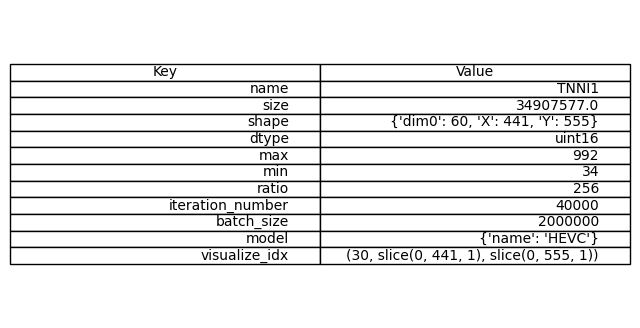

In [6]:
meta_data['ratio'] = ratio_slider.value
meta_data['iteration_number'] = iteration_slider.value
meta_data['batch_size'] = batch_size_slider.value
meta_data['model'] = {}
meta_data['model']['name']= model_selector.value
meta_data['visualize_idx'] = visual_tracker.get_indices()
visualizer.display_metadata(meta_data)

## 3. Initialize the model

In [7]:

if meta_data['model']['name'] == 'HEVC':
    ROI_data = others.denorm(ROI_data, meta_data)
    ROI_data = ROI_data.astype(meta_data['dtype'])
else:
    sampler = others.Sampler(ROI_data, meta_data)
    model, params, opt, opt_state = INR.get_model_param_opt_optstate(meta_data)

## 4. Define the training loop

In [8]:
def loss(params, key, model, x, y, aux_loss):
    pred = model.apply(params, key, x)
    mse = jnp.mean((pred - y)**2)
    total_loss = mse + aux_loss
    return total_loss, (mse, aux_loss)

def update(params, opt, opt_state, model, x, y, aux_loss = 0):
    (loss_val, (mse, aux_loss)), grads = jax.value_and_grad(loss, has_aux=True)(params, None, model, x, y, aux_loss)
    updates, new_opt_state = opt.update(grads, opt_state, params, extra_args={'loss': loss_val})
    new_params = optax.apply_updates(params, updates)
    return loss_val, new_params, new_opt_state, mse, aux_loss

def auto_pre_check_INR(meta_data, model, params, opt, opt_state, sampler):        
    while True:
        try:
            # Attempt to train with the current batch size
            print(f'Trying batch size: {sampler.batch_size}')
            x, y = sampler.next()
            loss_val, params, opt_state, mse, aux_loss = update(params, opt, opt_state, model, x, y)
            break  # If successful, break out of the loop
        except:
            # If an exception occurs, reduce the batch size
            print(f"Failed. Reducing batch size automatically...")
            if sampler.batch_size < 1:
                raise ValueError("Batch size cannot be reduced below 1.")
            sampler.batch_size = round(sampler.batch_size*0.9) # Set new batch size in the sampler

    meta_data['batch_size'] = sampler.batch_size
    meta_data['loop_number'] = meta_data["iteration_number"]*sampler.batch_size/ROI_data.size
    print(f'Batch size: {sampler.batch_size}, Iteration number: {meta_data["iteration_number"]}')
    print(f'We approximately loop trough the data {meta_data["loop_number"] : 4f} times')
    print('########## Metadata ##########')
    visualizer.display_metadata(meta_data)
        
def auto_pre_check_HEVC(meta_data, data, crf_min=0, crf_max=51, tolerance=1, max_iterations=10):
    target_ratio = meta_data['ratio']
    iteration = 0
    while crf_min < crf_max and iteration < max_iterations:
        iteration += 1
        crf_mid = (crf_min + crf_max) / 2  # current CRF
        
        # test the current CRF
        meta_data['crf'] = crf_mid
        actual_ratio = HEVC.compress(data, meta_data)
        diff = abs(actual_ratio - target_ratio)
        
        if diff <= tolerance:  # if the difference is within the tolerance, return the CRF
            exit(f'CRF: {crf_mid}, Actual Ratio: {actual_ratio}, Target Ratio: {target_ratio}')
        elif actual_ratio > target_ratio:  # if the actual ratio is less than the target ratio, decrease CRF
            crf_max = crf_mid
        else:  # if the actual ratio is greater than the target ratio, increase CRF
            crf_min = crf_mid

    # if the loop ends without finding the CRF, return the average of the min and max CRF
    meta_data['crf'] = (crf_min + crf_max) / 2
    print('########## Metadata ##########')
    visualizer.display_metadata(meta_data)
    
        
 
def train(meta_data, model, params, opt, opt_state, sampler):
    print('########## Compressing ##########')
    iteration_number = meta_data['iteration_number']
    progress_bar = tqdm(range(iteration_number))
    for step in progress_bar:
        x, y = sampler.next()
        loss_val, params, opt_state, mse, aux_loss = update( params, opt, opt_state, model, x, y)
        progress_bar.set_description(f'Loss: {loss_val:.6f},  MSE: {mse:.6f}, Aux Loss: {aux_loss:.6f}')
        if step % 100 == 0:
            # clean the previous plots
            slice_coords, image_shape = visualizer.get_slice( meta_data, meta_data['visualize_idx'], downsample_ratio=2)
            slice_values = ROI_data[meta_data['visualize_idx']] 
            decode_image = model.apply(params, None, slice_coords).reshape(image_shape)
            clear_output(wait=True)
            visualizer.plot2d(slice_values)
            visualizer.plot2d(decode_image)
    return meta_data, model, params


## 5. Final check before compression

Padded image shape (60, 442, 556, 1)
Compressed Done!
HEVC CRF:25.5, compressed bpp:547.6526822041429
Original_MB:33.290459632873535MB
compressed_MB:0.0061969757080078125MB
target ratio : 256
actual ratio : 5372.049399815328
Remove ../save/test.mp4
Padded image shape (60, 442, 556, 1)
Compressed Done!
HEVC CRF:12.75, compressed bpp:547.6526822041429
Original_MB:33.290459632873535MB
compressed_MB:0.01897907257080078MB
target ratio : 256
actual ratio : 1754.0614541982816
Remove ../save/test.mp4
Padded image shape (60, 442, 556, 1)
Compressed Done!
HEVC CRF:6.375, compressed bpp:547.6526822041429
Original_MB:33.290459632873535MB
compressed_MB:0.029384613037109375MB
target ratio : 256
actual ratio : 1132.921491626639
Remove ../save/test.mp4
Padded image shape (60, 442, 556, 1)
Compressed Done!
HEVC CRF:3.1875, compressed bpp:547.6526822041429
Original_MB:33.290459632873535MB
compressed_MB:0.029557228088378906MB
target ratio : 256
actual ratio : 1126.3051979479237
Remove ../save/test.mp4
Pa

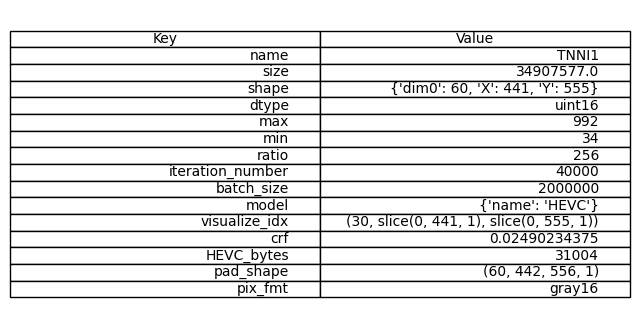

In [9]:
if meta_data['model']['name'] == 'HEVC':
    auto_pre_check_HEVC(meta_data, ROI_data)
else:
    auto_pre_check_INR(meta_data, model, params, opt, opt_state, sampler)

## 6. Training the model

In [10]:
if meta_data['model']['name'] == 'HEVC':
    save_name = f'../save/HEVC_name_{meta_data["name"]}_ratio_{meta_data["ratio"]}_crf_{meta_data["crf"]}.mp4'
    HEVC.compress(ROI_data, meta_data, save_name, test_only=False)
    decompressed_data = HEVC.decompress(save_name,meta_data)
    visualizer.DataVisualizer(decompressed_data, meta_data['shape'])
else:
    meta, model, params = train(meta_data, model, params, opt, opt_state, sampler)

Padded image shape (60, 442, 556, 1)
Compressed Done!
HEVC CRF:0.02490234375, compressed bpp:547.6526822041429
Original_MB:33.290459632873535MB
compressed_MB:0.029567718505859375MB
target ratio : 256
actual ratio : 1125.9055928267321


Output()

## 7. Save file

In [11]:
if meta_data['model']['name'] != 'HEVC':
    others.save(meta_data, params)
else:
    # we move the mp4 and the metadata to the save folder
    folder_path = save_name.split('.mp4')[0]
    os.makedirs(folder_path, exist_ok=True)
    os.rename(save_name, f'{folder_path}/compressed.mp4')
    others.save(meta_data, None, folder_path)

Moving the compressed video to ../save/HEVC_name_TNNI1_ratio_256_crf_0.02490234375
saved at ../save/HEVC_name_TNNI1_ratio_256_crf_0.02490234375/meta_data.pkl
